# isogonal_hessian

> Study projection of cell-shape elasticity onto space of isogonal modes

In [ ]:
#| default_exp hessian

In [ ]:
#| export

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso

In [ ]:
#| export
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import optimize, ndimage, sparse

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
#| export

from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import jax.numpy as jnp
from jax import jit
import jax
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
#| export

import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
#| notest

import importlib

In [ ]:
importlib.reload(msh)
importlib.reload(tns)
importlib.reload(dln)
importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

## Add methods to the HalfEdgeMesh class to compute isogonal modes

In [ ]:
#| export

@patch
def get_isogonal(self: msh.Vertex) -> Dict[int, NDArray[Shape["2"], Float]]:
    """
    Get isogonal mode for a given cell.
    
    Returns a dict: {faceid: translation vector} of primal vertices. Entries are
    
    j: T_j,bc / S_{self}bc
    
    where self,b,c are the three cells meeting at vertex j, and S is the area of the tension triangle.
    T_j is pointing towards vertex j (i.e. inwards)
    
    """

    # iterate over faces (cell vertices) adjacent to self. note: these are ccwise ordered by construction.
    isogonal_dict = {}
    for fc in self.faces:
        if fc is not None:
            S = fc.get_area()
            he = next(he for he in fc.hes if not self in he.vertices)            
            # note: hes are oriented ccwise
            T = dln.rot_mat(-np.pi/2)@(he.vertices[1].coords - he.vertices[0].coords)
            isogonal_dict[fc._fid] = T/S
        
    return isogonal_dict

In [ ]:
dln.rot_mat(np.pi/2) @ np.array([1,0])  # clockwise

array([ 6.123234e-17, -1.000000e+00])

In [ ]:
mesh = dln.get_tri_hemesh()
mesh.set_voronoi()

v = mesh.vertices[30]
nghbs = v.faces
v, nghbs[0]

(Vertex(vid=30, coords=[0.5 0.9], incident hes=[138, 141, 155, 145, 148, 152]),
 Face(fid=46, primal_coords=[0.0, 0.6], hes=[138, 139, 140]))

<matplotlib.collections.PathCollection>

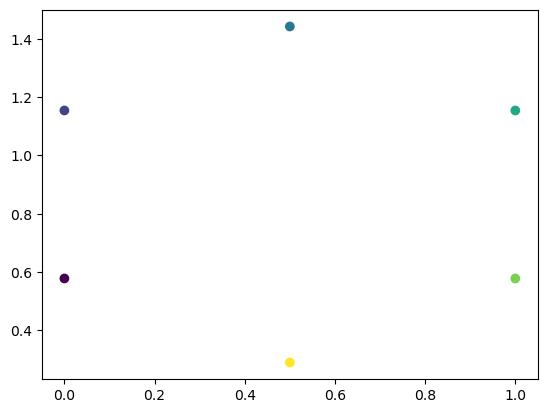

In [ ]:
# checking orientation conventions

#face = np.array([he.vertices[0].coords for he in nghbs[0].hes])
#plt.scatter(*face.T, c=np.arange(face.shape[0]))

cell = np.array([fc.primal_coords for fc in nghbs])
plt.scatter(*cell.T, c=np.arange(cell.shape[0]))

In [ ]:
tns.polygon_perimeter(cell), 2*np.sqrt(3)

(DeviceArray(3.46462119, dtype=float64), 3.4641016151377544)

In [ ]:
iso_dict = v.get_isogonal()
iso_dict

{46: array([-2.        , -1.15470054]),
 47: array([-2.        ,  1.15470054]),
 51: array([1.41410032e-16, 2.30940108e+00]),
 50: array([2.        , 1.15470054]),
 49: array([ 2.        , -1.15470054]),
 48: array([-1.41410032e-16, -2.30940108e+00])}

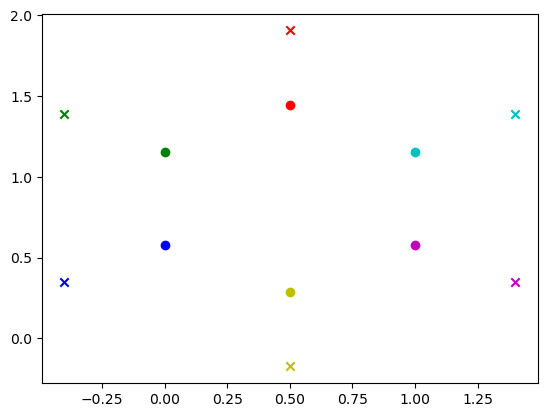

In [ ]:
colors = list(mpl.colors.BASE_COLORS.values())
for c, fc in zip(colors, nghbs):
    plt.scatter(*fc.primal_coords, color=c)
    plt.scatter(*(fc.primal_coords+.2*iso_dict[fc._fid]), color=c, marker='x')


In [ ]:
mesh = msh.get_test_hemesh_large()
mesh.set_voronoi()
print(len(mesh.vertices))

1250


In [ ]:
%%time
iso_dicts = {key: val.get_isogonal() for key, val in mesh.vertices.items()}

# not super fast, but ok.

CPU times: user 659 ms, sys: 0 ns, total: 659 ms
Wall time: 659 ms


In [ ]:
#| export

@patch
def get_isogonal_transform_matrix(self: msh.HalfEdgeMesh, flattened=False) -> NDArray[Shape["*,*,2"], Float]:
    """
    Create a matrix that transforms isogonal modes to vertex displacement
    
    To do the basis conversion, order vertices (cells) and faces (cell vertices) according to their indices.
    
    If flattened, flatten by combining face & x/y-component index
    
    """    
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    vertex_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    
    iso_matrix = np.zeros((len(self.vertices), len(self.faces), 2))
    iso_dicts = {key: val.get_isogonal() for key, val in self.vertices.items()}

    for vkey, iso_dict in iso_dicts.items():
        for fkey, dr in iso_dict.items():
            iso_matrix[vertex_key_dict[vkey], face_key_dict[fkey], :] = dr
    if flattened:
        return iso_matrix.reshape((iso_matrix.shape[0], iso_matrix.shape[1]*iso_matrix.shape[2]))
    return iso_matrix

In [ ]:
# timing

mesh = msh.get_test_hemesh_large()
mesh.set_voronoi()
print(len(mesh.vertices))

%time iso_matrix = mesh.get_isogonal_transform_matrix()
print(iso_matrix.shape, np.mean(iso_matrix >0))

# note: very sparse ofc

1250
CPU times: user 647 ms, sys: 0 ns, total: 647 ms
Wall time: 646 ms
(1250, 2352, 2) 0.0012


In [ ]:
## testing

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=.1))
mesh.set_voronoi()

iso_matrix = mesh.get_isogonal_transform_matrix()

iso_matrix.shape

(47, 70, 2)

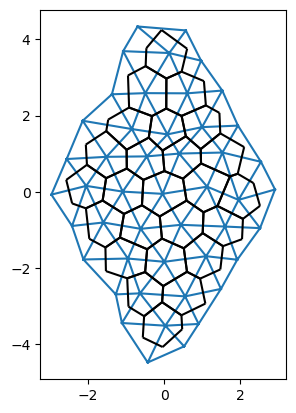

In [ ]:
mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
## test that isogonal modes don't affect the angle penalty

print('pre', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

theta = np.random.normal(scale=.05, size=len(mesh.vertices))
dr = np.einsum('i,ijk', theta, iso_matrix)
x0 = mesh.primal_vertices_to_vector(flattened=False)

new_positions = mesh.vector_to_primal_vertices(x0 + dr, flattened=False)
for key, val in mesh.faces.items():
    val.primal_coords = new_positions[key]

print('mean translation', np.linalg.norm(dr, axis=1).mean())
    
print('post', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

pre 8.276712648580524e-16
mean translation 0.20758328369761322
post 3.793770853022216e-15


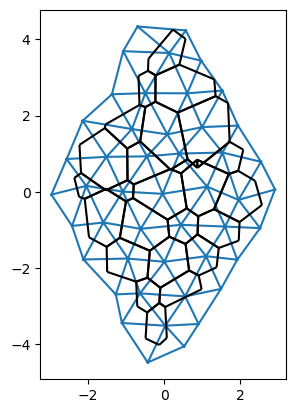

In [ ]:
mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
sorted(list(mesh.get_primal_edge_lens(oriented=True).values()))[:3] # some edge collapses = negative lengths

[-0.20976576967479885, -0.03802586461868229, -0.017968329877702735]

In [ ]:
## check same thing but for "flattened" version to check everything works

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=.1))
mesh.set_voronoi()
iso_matrix = mesh.get_isogonal_transform_matrix(flattened=True)


print('pre', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

theta = np.random.normal(scale=.05, size=len(mesh.vertices))
dr = theta @ iso_matrix
x0 = mesh.primal_vertices_to_vector(flattened=True)

new_positions = mesh.vector_to_primal_vertices(x0 + dr, flattened=True)
for key, val in mesh.faces.items():
    val.primal_coords = new_positions[key]

print('mean translation', np.linalg.norm(deflatten(dr), axis=1).mean())
    
print('post', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

pre 6.250555628639626e-16
mean translation 0.1955358875469758
post 8.473222123939162e-15


In [ ]:
# comparing this to a random translation

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh())
mesh.set_voronoi()
x0 = mesh.primal_vertices_to_vector(flattened=False)

dr_random = np.random.normal(size=(len(mesh.faces), 2), scale=.1)

new_positions = mesh.vector_to_primal_vertices(x0 + dr_random, flattened=False)
for key, val in mesh.faces.items():
    val.primal_coords = new_positions[key]

print('mean translation', np.linalg.norm(dr_random, axis=1).mean())

print('post random', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

mean translation 0.1314988893095166
post random 0.5529270542144731


## TO DO: Infer isogonal modes globally by comparing to Voronoi reference state and solving linear eqs.

In [ ]:
## test case: reference voronoi, plus isogonally transformed

mesh_ref = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=.1))
mesh_ref.set_voronoi()

iso_matrix = mesh_ref.get_isogonal_transform_matrix(flattened=True)
theta = np.random.normal(scale=.1, size=len(mesh_ref.vertices))
theta -= theta.mean() # mean theta has no effect so normalize away

mesh_new = deepcopy(mesh_ref)
x0 = mesh_new.primal_vertices_to_vector(flattened=True)
new_positions = mesh.vector_to_primal_vertices(x0 + theta@iso_matrix, flattened=True)
for key, val in mesh_new.faces.items():
    val.primal_coords = new_positions[key]

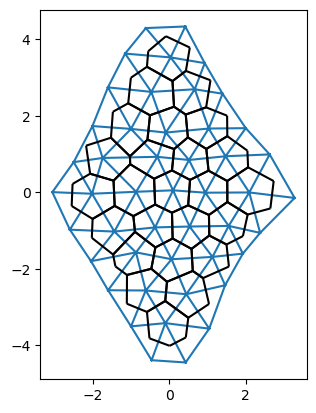

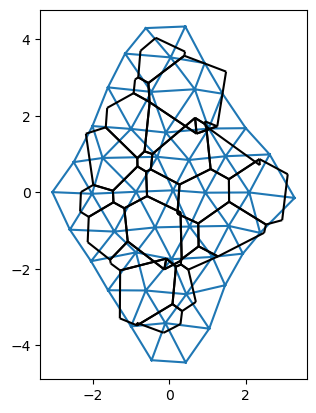

In [ ]:
mesh_ref.triplot(); mesh_ref.cellplot(); plt.gca().set_aspect('equal')
plt.show()

mesh_new.triplot(); mesh_new.cellplot(); plt.gca().set_aspect('equal')
plt.show()

Now infer the isogonal transform by solving for theta using least squares:
    
$$ \mathbf{x} =  \mathbf{x}_\text{Voronoi} + \text{Iso}^T \cdot \theta$$

where $\text{Iso}$ is the isogonal matrix of shape $(n_\text{cells}, n_\text{vertices})$

In [ ]:
x_new = mesh_new.primal_vertices_to_vector()
x_ref = mesh_ref.primal_vertices_to_vector()

theta_lstsq, _, _,  _ = np.linalg.lstsq(iso_matrix.T, x_new-x_ref, rcond=None)
theta_lstsq -= theta_lstsq.mean()

In [ ]:
mesh_infered = deepcopy(mesh_ref)
x0 = mesh_infered.primal_vertices_to_vector(flattened=True)
new_positions = mesh_infered.vector_to_primal_vertices(x0 + theta_lstsq@iso_matrix, flattened=True)
for key, val in mesh_infered.faces.items():
    val.primal_coords = new_positions[key]

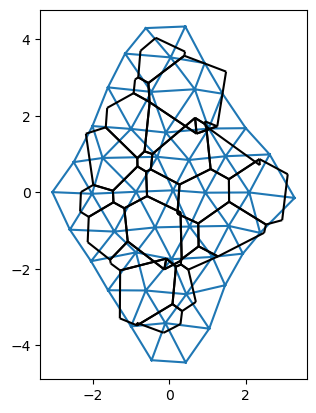

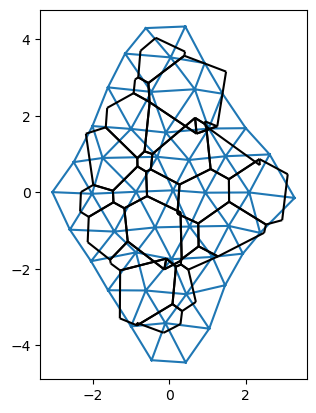

In [ ]:
mesh_infered.triplot(); mesh_infered.cellplot(); plt.gca().set_aspect('equal')
plt.show()

mesh_new.triplot(); mesh_new.cellplot(); plt.gca().set_aspect('equal')
plt.show()

In [ ]:
#| export

def get_isogonal_trafo(mesh: msh.HalfEdgeMesh, mesh_ref=None) -> Dict[int, float]:
    """
    Get isogonal trafo from mesh_ref->mesh, or, if mesh_ref is None, from isogonal reference to mesh.
    
    By convention, the sum of all isogonal modes is set to 0. Results are returned as a dict {vertex: theta}.
    """
    if mesh_ref is None:
        mesh_ref = deepcopy(mesh_ref)
        mesh_ref.set_voronoi()
    
    x = mesh.primal_vertices_to_vector()
    x_ref = mesh_ref.primal_vertices_to_vector()

    theta_lstsq = np.linalg.lstsq(iso_matrix.T, x-x_ref, rcond=None)[0]
    theta_lstsq -= theta_lstsq.mean()

    return mesh.vector_to_vertices(theta_lstsq)
    

## Getting the JAX hessian

In [ ]:
#| export

get_E_hessian = jit(jax.hessian(iso.get_E))

## Testing 

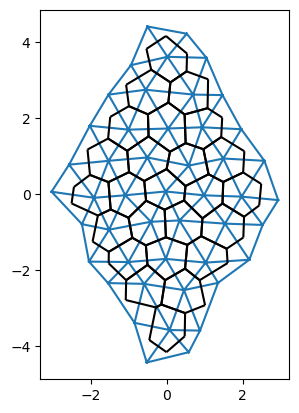

In [ ]:
mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=0.1))
iso_matrix = mesh.get_isogonal_transform_matrix()

mesh.set_voronoi()

mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
x0 = mesh.primal_vertices_to_vector()
serialized_dict, _ = mesh.serialize_primal()

iso.get_E(x0, **serialized_dict, mod_area=1, angle_penalty=0)

DeviceArray(0.00260733, dtype=float64)

In [ ]:
# check 
areas = np.array([x for x in mesh.get_areas().values() if x is not None])
np.mean((areas -np.sqrt(3)/2)**2)

0.002607327194660891

In [ ]:
# now compute the hessian

hess = get_E_hessian(x0, **serialized_dict, mod_area=1, angle_penalty=0)

hess.shape, iso_matrix.shape

((140, 140), (47, 70, 2))

In [ ]:
# a,b,c =  cells. i,j,k = spatial components (x/y). f,g,h = faces

iso_matrix_flat = mesh.get_isogonal_transform_matrix(flattened=True)

projected_hess = iso_matrix_flat @ hess @ iso_matrix_flat.T

projected_hess.shape

(47, 47)

## Loading a disordered mesh

## Diagonlization, direct & dense

Compute the Hessian -> multiply with matrices to project onto isogonal modes -> diagonalize

Do all of it using direct diag & dense matrices. Later, for large systems, it might be appropriate to use indirect computation of the Jacobian/vector product, sparse matrices to represent the isogonal modes, and iterative diagonalization (e.g. Lanzos).

In [ ]:
## triangular lattice with voronoi

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=0.15, nx=11, ny=11))  #(7,13)  -(15, 19), (9,9)
mesh.transform_vertices(dln.shear_mat(1.05))

iso_matrix = mesh.get_isogonal_transform_matrix(flattened=False)
iso_matrix_flat = mesh.get_isogonal_transform_matrix(flattened=True)
serialized_dict, _ = mesh.serialize_primal()

#mesh.flip_edge(20)
#mesh.flip_edge(40)
#mesh.flip_edge(50)


mesh.set_voronoi()

In [ ]:
sol = mesh.optimize_cell_shape(energy_args={'mod_area': 0, 'mod_perimeter': 0,
                                            'mod_bulk': 1, 'mod_shear': 1,
                                            'rest_shape': np.sqrt(3)*np.eye(2),
                                            'angle_penalty': 1000},
                               tol=1e-4, maxiter=50000, return_sol=True)

#flip = mesh.intercalate(exclude=[], minimal_l=.1, reoptimize=False)
#print(flip)
#sol = mesh.optimize_cell_shape(energy_args={'mod_area': 1, 'mod_perimeter': 1, 'angle_penalty': 1000},
#                               tol=1e-4, maxiter=50000)

sol['fun']

Overriding mesh values for rest_shape with manually provided value


0.11187154290653456

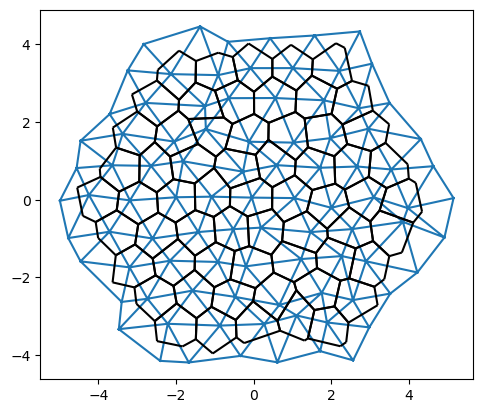

In [ ]:
mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
%%time

x0 = mesh.primal_vertices_to_vector()

hess = get_E_hessian(x0, **serialized_dict,
                     mod_bulk=1, mod_shear=1,
                     mod_area=0, mod_perimeter=0)
projected = iso_matrix_flat @ hess @ iso_matrix_flat.T
vals, vecs = np.linalg.eigh(projected)

CPU times: user 2.16 s, sys: 30.2 ms, total: 2.19 s
Wall time: 2.16 s


In [ ]:
E = iso.get_E(x0, **serialized_dict, mod_bulk=1, mod_shear=1, mod_area=0, mod_perimeter=0 ,angle_penalty=0)

E # .14 if not optimized. so we are certainly not at a minimum!

DeviceArray(3.23229061, dtype=float64)

In [ ]:
vals.shape, np.mean(vals < 1e-6)

# 100% 0 modes for mod_area = 0, mod_perimeter = 0
# 65% 0 modes for mod_area = 1, mod_perimeter = 0
# 43% 0 modes for mod_area = 0, mod_perimeter = 1
# 48% 0 modes for mod_area = 1, mod_perimeter = 1

# the degeneracy appears for a large mesh! for smaller meshes

((91,), 0.03296703296703297)

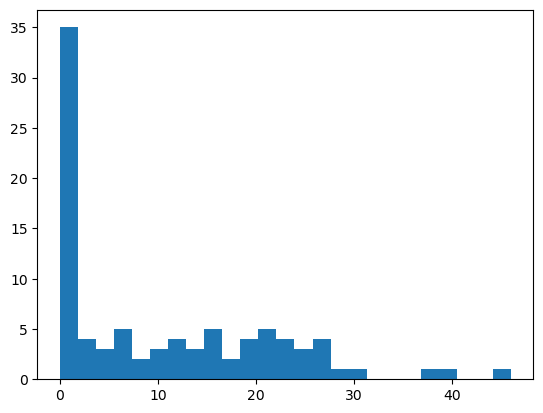

In [ ]:
plt.hist(vals, bins=25);
#plt.ylim([0, 20])

In [ ]:
## plot the localization!

np.round(100*np.sort(np.abs(vecs[:,0])), decimals=1)

array([ 0. ,  0.1,  0.3,  0.4,  0.5,  0.7,  1.1,  1.7,  1.7,  1.8,  2.1,
        2.1,  2.4,  2.5,  2.6,  2.6,  2.7,  2.8,  2.8,  3.1,  3.3,  3.7,
        3.9,  4.1,  4.4,  4.5,  4.5,  4.6,  5. ,  5. ,  5.2,  5.2,  5.4,
        5.5,  5.6,  5.7,  5.9,  6.4,  6.5,  6.9,  7.2,  7.9,  8. ,  8. ,
        8.2,  8.5,  8.8,  9.3,  9.4,  9.4,  9.6,  9.6,  9.7,  9.7,  9.8,
       10.2, 10.3, 10.5, 10.7, 10.8, 11. , 11.2, 11.5, 11.5, 11.6, 11.6,
       12.6, 12.9, 12.9, 12.9, 12.9, 13.3, 13.8, 14.1, 14.2, 14.2, 14.3,
       15.2, 16. , 16.1, 16.1, 17.5, 18. , 18.1, 18.5, 18.6, 19.2, 19.8,
       21.1, 22.5, 22.7])

In [ ]:
#| export

def top_q_share(x, q=.9):
    return np.round(x[x > np.quantile(x, q)].sum() / x.sum(), decimals=2)

In [ ]:
normalized = (vecs.T)**2 / (vecs.T**2).sum(axis=1)

top_q_share(normalized[0], .95), top_q_share(normalized[-1], .95)

(0.22, 0.99)

(array([ 9., 16.,  9., 19., 14.,  6.,  7.,  4.,  3.,  4.]),
 array([0.19, 0.27, 0.35, 0.43, 0.51, 0.59, 0.67, 0.75, 0.83, 0.91, 0.99]),
 <BarContainer object of 10 artists>)

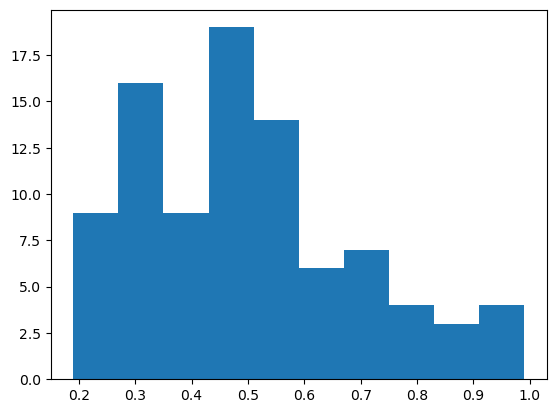

In [ ]:
plt.hist([top_q_share(x, .95) for x in normalized])

<matplotlib.collections.LineCollection>

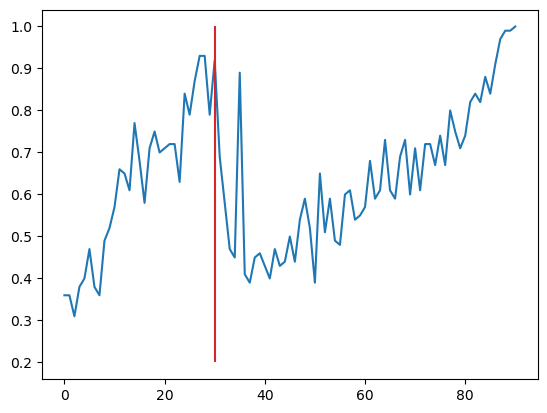

In [ ]:
plt.plot([top_q_share(x, .9) for x in normalized])
plt.vlines(30, .2, 1, color='tab:red')

<matplotlib.collections.PathCollection>

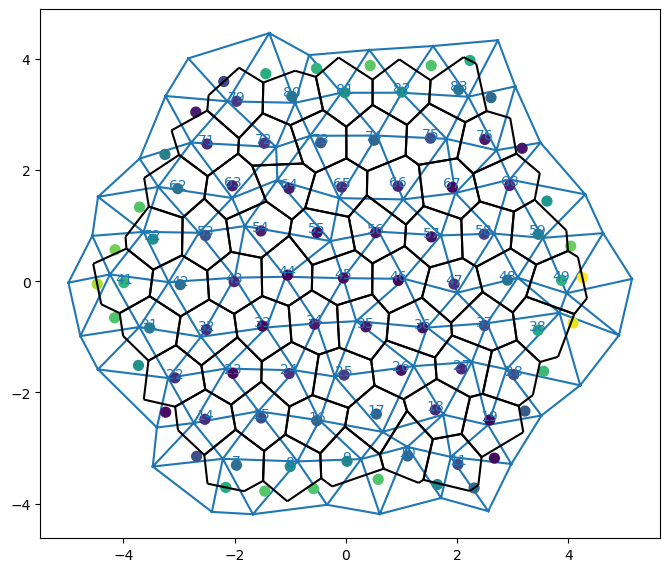

In [ ]:
## spatial plot of magnitudes

fig = plt.figure(figsize=(8,8))

plt.gca().set_aspect("equal", adjustable="box")
mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

# now calculate the energies and centroids

iso_mode = mesh.vector_to_vertices(np.abs(vecs[:, 3]), flattened=False)

for_scttr = np.stack([np.hstack([mesh.vertices[key].get_centroid(), [val]])
                      for key, val in iso_mode.items()], axis=1)
plt.scatter(*for_scttr[:2], c=for_scttr[2], vmin=0, vmax=.25, s=50)

# 0 = linear gradient i.e. translation. 3 = quadratic i.e. shear

## test - apply a trafo based on the lowest eigenvec and see whether energy changes

In [ ]:
vals[20], vals.shape

(0.6246463740456134, (91,))

In [ ]:
mesh_new = deepcopy(mesh)

theta = .1 * vecs[:, 75] # 0, 1, 2 = translation. 3, 4 = shear. then come a bunch localized at the bdry,
dr = theta @ iso_matrix_flat
x0 = mesh_new.primal_vertices_to_vector()

new_positions = mesh_new.vector_to_primal_vertices(x0 + dr)
for key, val in mesh_new.faces.items():
    val.primal_coords = new_positions[key]


In [ ]:
np.linalg.norm(deflatten(dr), axis=1).mean() # .035 -> .039

0.041715829602455956

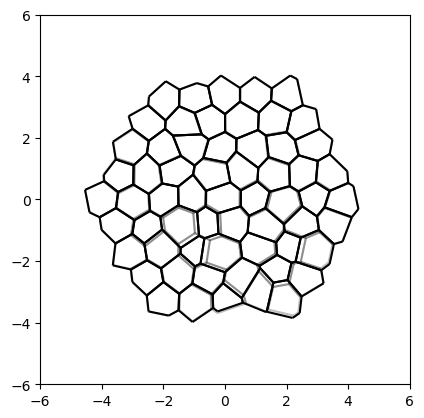

In [ ]:
mesh.cellplot(alpha=.25)
mesh_new.cellplot()
#mesh_new.triplot()
#mesh_new.labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

lim = 6
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

plt.gca().set_aspect("equal", adjustable="box")

# mode 30 - lowest non-edge mode - is a radial shear.

# multipole shear expansion?

# for shape energy, it looks more like localization at pairs of cells. 

In [ ]:
x0_pre = mesh.primal_vertices_to_vector()
x0_post = mesh_new.primal_vertices_to_vector()

energy_arrays = mesh_new.get_iso_energy_fct_jax()

print('pre iso', get_E_iso(x0_pre, *energy_arrays, mod_area=1, mod_perimeter=1))
print('post iso', get_E_iso(x0_post, *energy_arrays, mod_area=1, mod_perimeter=1))

# .03 -> .06 for lowest mode
# .03 -> .12 for highest mode

# looks like the isogonal modes work roughly as expected.
# the null modes increase energy less than the highest modes.

# presumably we should evaluate this around the minimum.


# as expected, lowest eigenvector is a translation!

pre iso 0.009930021325488673
post iso 0.08614431992784415
